# MUJOCO Differential Drive
В этом домашнем задании мы познакомимся с симулятором [Mujoco](https://github.com/google-deepmind/mujoco).


In [1]:
# !git clone https://github.com/google-deepmind/mujoco_menagerie.git # Repo with models for mujoco

In [2]:
# !pip install mujoco
'''
# Set up GPU rendering.
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

''' 

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


In [3]:
# !pip install tqdm

In [4]:
from pathlib import Path
import enum
from tqdm import tqdm

## Helper methods

In [5]:
class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)


def quartic(t: float) -> float:
  return 0 if abs(t) > 1 else (1 - t**2) ** 2


def blend_coef(t: float, duration: float, std: float) -> float:
  normalised_time = 2 * t / duration - 1
  return quartic(normalised_time / std)


def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time * 2 * np.pi)


def azimuth(
    time: float, duration: float, total_rotation: float, offset: float
) -> float:
  return offset + unit_smooth(time / duration) * total_rotation

## Parameters

In [6]:
res = Resolution.SD
fps = 60
duration = 10.0
ctrl_rate = 2
ctrl_std = 0.05
total_rot = 60
blend_std = .8

In [7]:
h, w = res.value

## Loading and rendering the model

In [8]:
model_dir = Path("mujoco_menagerie/hello_robot_stretch") # You could also use google_robot
model_xml = model_dir / "scene.xml"

In [9]:
# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

In [25]:
model.body(7)   # link_right_wheel - 7


<_MjModelBodyViews
  dofadr: array([6], dtype=int32)
  dofnum: array([1], dtype=int32)
  geomadr: array([32], dtype=int32)
  geomnum: array([3], dtype=int32)
  id: 7
  inertia: array([0., 0., 0.])
  invweight0: array([   0.106, 1625.438])
  ipos: array([-0.   , -0.   ,  0.013])
  iquat: array([ 0.372,  0.602, -0.372,  0.602])
  jntadr: array([1], dtype=int32)
  jntnum: array([1], dtype=int32)
  mass: array([0.15])
  mocapid: array([-1], dtype=int32)
  name: 'link_right_wheel'
  parentid: array([1], dtype=int32)
  pos: array([ 0.   , -0.17 ,  0.051])
  quat: array([ 0.707, -0.707,  0.   ,  0.   ])
  rootid: array([1], dtype=int32)
  sameframe: array([0], dtype=uint8)
  simple: array([0], dtype=uint8)
  subtreemass: array([0.15])
  user: array([], dtype=float64)
  weldid: array([7], dtype=int32)
>

In [11]:
model.body(8)   # link_left_wheel - 8

<_MjModelBodyViews
  dofadr: array([7], dtype=int32)
  dofnum: array([1], dtype=int32)
  geomadr: array([35], dtype=int32)
  geomnum: array([3], dtype=int32)
  id: 8
  inertia: array([0., 0., 0.])
  invweight0: array([   0.102, 1625.438])
  ipos: array([ 0.   ,  0.   , -0.013])
  iquat: array([ 0.163,  0.688, -0.163,  0.688])
  jntadr: array([2], dtype=int32)
  jntnum: array([1], dtype=int32)
  mass: array([0.15])
  mocapid: array([-1], dtype=int32)
  name: 'link_left_wheel'
  parentid: array([1], dtype=int32)
  pos: array([0.   , 0.17 , 0.051])
  quat: array([ 0.707, -0.707,  0.   ,  0.   ])
  rootid: array([1], dtype=int32)
  sameframe: array([0], dtype=uint8)
  simple: array([0], dtype=uint8)
  subtreemass: array([0.15])
  user: array([], dtype=float64)
  weldid: array([8], dtype=int32)
>

In [12]:
# model.body_pos[-2:] = [100, 100, 1] # move table with object away

In [13]:
# data.joint('joint_left_wheel').qvel = np.array([2.])
# data.joint('joint_right_wheel').qvel = np.array([2.])
data.joint('joint_left_wheel').qvel

array([0.])

In [14]:
data.joint('joint_right_wheel').qvel

array([0.])

""

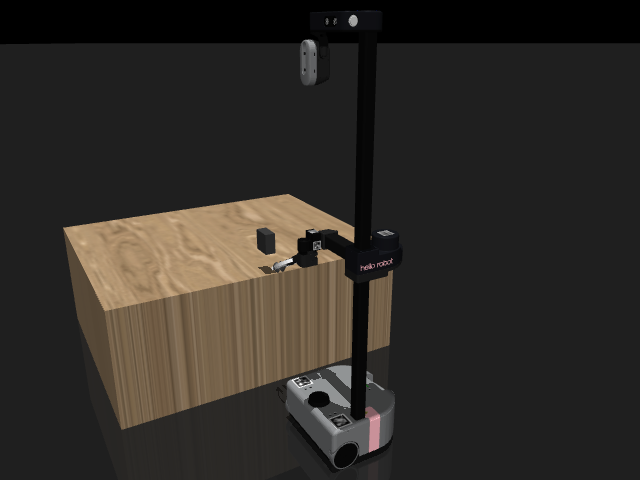

In [15]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

## Checking for keyframes

In [16]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [17]:
data.joint('joint_right_wheel')

<_MjDataJointViews
  cdof: array([[0., 0., 0., 0., 1., 0.]])
  cdof_dot: array([[0., 0., 0., 0., 0., 0.]])
  id: 1
  name: 'joint_right_wheel'
  qLDiagInv: array([4872.831])
  qLDiagSqrtInv: array([69.806])
  qacc: array([0.002])
  qacc_smooth: array([0.001])
  qacc_warmstart: array([0.002])
  qfrc_actuator: array([0.])
  qfrc_applied: array([0.])
  qfrc_bias: array([-0.])
  qfrc_constraint: array([0.])
  qfrc_inverse: array([0.])
  qfrc_passive: array([0.])
  qfrc_smooth: array([0.])
  qpos: array([0.])
  qvel: array([0.])
  xanchor: array([ 0.   , -0.17 ,  0.051])
  xaxis: array([ 0., -1., -0.])
>

## Render!

In [27]:
np.random.seed(12345)

# Rendering options for visual and collision geoms.
vis = mujoco.MjvOption()
vis.geomgroup[2] = True
vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

# Create a camera that will revolve around the robot.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 4
offset = model.vis.global_.azimuth

# Sample actuator noise and smooth it.
nsteps = int(np.ceil(duration / model.opt.timestep))
perturb = np.random.randn(nsteps, model.nu)
width = int(nsteps * ctrl_rate / duration)
kernel = np.exp(-0.5 * np.linspace(-3, 3, width) ** 2)
kernel /= np.linalg.norm(kernel)

for i in range(model.nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode="same")

# Set the desired control point.
if model.nkey > 0:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  ctrl0 = data.ctrl.copy()
else:
  mujoco.mj_resetData(model, data)
  ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)

frames = []
for i in tqdm(range(nsteps)):
  data.ctrl[:] = ctrl0  + ctrl_std * perturb[i] # random perturbations

  # data.ctrl[:2] = 0
  data.ctrl[0] = -1
  data.ctrl[1] = -1
  mujoco.mj_step(model, data)
  if len(frames) < data.time * fps:
    # camera.azimuth = azimuth(data.time, duration, total_rot, offset)  # camera motion
    renderer.update_scene(data, camera, scene_option=vis)
    vispix = renderer.render().copy().astype(np.float32)
    frame = vispix.astype(np.uint8)
    frames.append(frame)

media.show_video(frames, fps=fps, loop=False)

100%|██████████| 5000/5000 [00:09<00:00, 546.71it/s]


In [19]:
# model.body(0)
# model.body(1)

In [20]:
# data.actuator(1)

## Homework
В этом домашнем задании вам нужно будет реализовать расчет колесной одометрии для робота. Вы можете использовать любого колесного робота из [Mujoco Menagerie](https://github.com/google-deepmind/mujoco_menagerie), но все они сделаны по принципу дифференциального привода (diff drive). Про кинематику можно почитать на [вики](https://en.wikipedia.org/wiki/Differential_wheeled_robot), а про расчет одометрии на [medium](https://medium.com/@nahmed3536/wheel-odometry-model-for-differential-drive-robotics-91b85a012299). За реализацию алгоритма расчета одометрии дается **6 баллов**. В данном задании в качестве обратной связи вы можете использовать только скорость.

Второй частью ДЗ будет исследование точности полученного алгоритма. В качестве метрики воспользуйтесь евклидовым растоянием между реальным положением робота и расчетным для конечной точки траектории. Покажите, что ваш алгоритм работает и для простых траекторий (робот вращается, едет прямо) и для сложных - **2 балла**.

Постройте траектории разной длины и нарисуйте график зависимости ошибки от длины траектории - **2 балла**. Траектория не должна быть простой.